In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
#import cv2
import os
from sklearn import utils
import json
import tensorflow as tf
from keras.applications import InceptionResNetV2
from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, Dropout
import pandas as pd

In [2]:
X_test = np.load('/content/drive/MyDrive/Colab Notebooks/X_test.npy')
y_test = np.load('/content/drive/MyDrive/Colab Notebooks/y_test.npy')

In [3]:
# Cargar modelos

model1 = load_model('/content/drive/MyDrive/Colab Notebooks/model1.h5')
model2 = load_model('/content/drive/MyDrive/Colab Notebooks/model2.h5')
model3 = load_model('/content/drive/MyDrive/Colab Notebooks/model3.h5')
model4 = load_model('/content/drive/MyDrive/Colab Notebooks/model4.h5')
model5 = load_model('/content/drive/MyDrive/Colab Notebooks/model5.h5')

# El Modelo6 necesita reconstruir su arquitectura para cargarse:
base_model = InceptionResNetV2(
    weights=None,  # No cargar pesos de ImageNet
    include_top=False,
    input_shape=(150, 150, 3)
)

base_model.trainable = False

limite_train = len(base_model.layers) - 30
for layer in base_model.layers[:limite_train]:
    layer.trainable = False
for layer in base_model.layers[limite_train:]: # Entrenamos las últimas 30 capas
    layer.trainable = True

model6 = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

# Lo que sí que cargamos son los pesos
model6.load_weights('/content/drive/MyDrive/Colab Notebooks/model6.h5')


In [4]:
# Cargar para las gráficas accuracy
with open('/content/drive/MyDrive/Colab Notebooks/hist_model1.json', 'r') as f:
    hist_model1 = json.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/hist_model2.json', 'r') as f:
    hist_model2 = json.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/hist_model3.json', 'r') as f:
    hist_model3 = json.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/hist_model4.json', 'r') as f:
    hist_model4 = json.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/hist_model5.json', 'r') as f:
    hist_model5 = json.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/hist_model6.json', 'r') as f:
    hist_model6 = json.load(f)

In [5]:
all_results = []  # Lista donde se almacenarán los resultados de evaluate

In [6]:
# Evaluamos todos los modelos y almacenamos los resultados
_, test_acc = model1.evaluate(X_test, y_test)
all_results.append(("base_model", test_acc))

47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7096 - loss: 1.1540


In [7]:
_, test_acc = model2.evaluate(X_test, y_test)
all_results.append(("advance_model", test_acc))

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7354 - loss: 1.2624


In [8]:
_, test_acc = model3.evaluate(X_test, y_test)
all_results.append(("hp", test_acc))

47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6868 - loss: 1.4690


In [9]:
_, test_acc = model4.evaluate(X_test, y_test)
all_results.append(("fine_tuning", test_acc))

47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 123ms/step - accuracy: 0.8793 - loss: 0.5909


In [10]:
_, test_acc = model5.evaluate(X_test, y_test)
all_results.append(("data_aug", test_acc))

47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 109ms/step - accuracy: 0.1874 - loss: 6.9067


In [11]:
model6.compile(optimizer="adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

_, test_acc = model6.evaluate(X_test, y_test)
all_results.append(("extra", test_acc))

47/47 ━━━━━━━━━━━━━━━━━━━━ 27s 185ms/step - accuracy: 0.8994 - loss: 0.4623


In [12]:
df = pd.DataFrame(all_results)
df.columns = ['Model_Name', 'Test_Accuracy']
df = df.style.background_gradient(cmap="coolwarm")
df

,Model_Name,Test_Accuracy
0,base_model,0.718539
1,advance_model,0.726658
2,hp,0.698917
3,fine_tuning,0.882273
4,data_aug,0.189445
5,extra,0.899865


In [ ]:
# Como se puede observar, el modelo5 (data augmentation), al usar datos modificados para
# el entrenamiento, es el que ofrece peores resultados.
# El mejor es el modelo6 (transfer learning con fine tuning), que ofrece cierta mejora
# sobre el modelo4 (también transfer learning, pero con otro modelo preentrenado de keras).

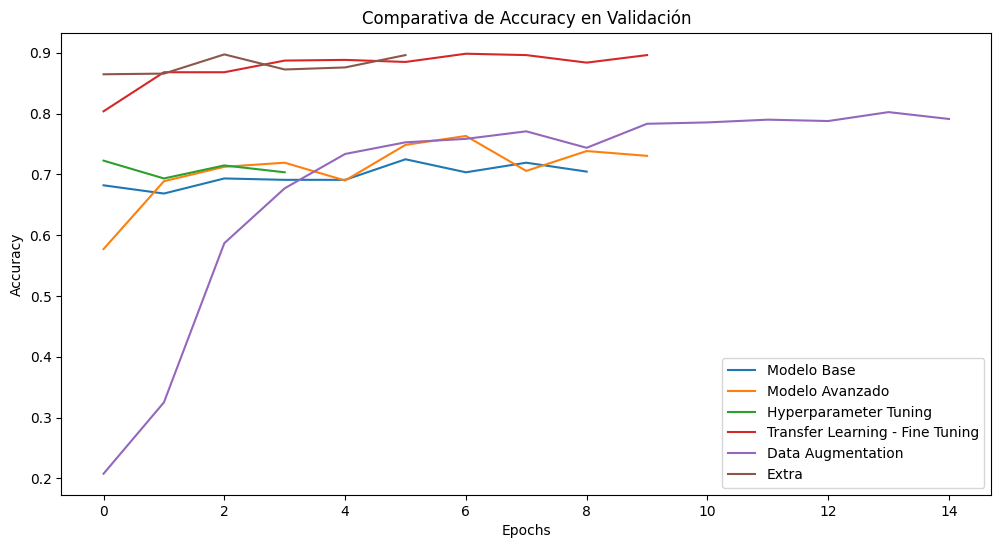

In [13]:
# Gráfica con el validation accuracy de los modelos

plt.figure(figsize=(12, 6))
plt.plot(hist_model1['val_accuracy'], label='Modelo Base')
plt.plot(hist_model2['val_accuracy'], label='Modelo Avanzado')
plt.plot(hist_model3['val_accuracy'], label='Hyperparameter Tuning')
plt.plot(hist_model4['val_accuracy'], label='Transfer Learning - Fine Tuning')
plt.plot(hist_model5['val_accuracy'], label='Data Augmentation')
plt.plot(hist_model6['val_accuracy'], label='Extra')
plt.title('Comparativa de Accuracy en Validación')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# La distinta longitud de las líneas en la gráfica se debe al uso de earlystopping.
# Algunos entrenamientos se cortaron antes porque el val_accuracy no mejoraba.